In [1]:
import IPython as ip

# Lecture 5.5

- Idea of parsing and parser combinators
- `Parser` type
    - Basic parsers
    - Instances: `Functor`, `Applicative`, `Monad`, `Alternative`
    - Usage examples
- Testing
    - [hspec](http://hackage.haskell.org/package/hspec)
    - [hedgehog](http://hackage.haskell.org/package/hedgehog)
    - [tasty](http://hackage.haskell.org/package/tasty)
    - Continuations as callbacks
    - [Cont](http://hackage.haskell.org/package/mtl/docs/Control-Monad-Cont.html#t:Cont) datatype and monadic example

## Idea

Parsing — process of converting poorly structured data (text, bytes) into strongly structured data (custom user data types)

Попробуем распарсить простой Инт:

Какой тип должен быть у парсера?
```
parseInteger :: String -> Bool
```
Это конечно хорошо, но как нам получить сам инт?
```
parseInteger :: String -> Integer
```
Лучше, но парсинг может зафэйлиться
```
parseInteger :: String -> Maybe Integer -- Either for more descriptive error
```

Хорошо, а теперь хотим парсить инты разделенные чем нибудь. Не останавливаться только на парсинге инта

Now. How do you parse two integers separated by space? Or by any number of spaces? Or comma-separated list of integers? Or the same list inside square brackets [] with any number of spaces between elements?
```
parseInteger :: String -> Maybe (Integer, String)
```


## Parsing

Перевод неструктурированных данных в строго структурированный вид

Хотим комбинировать различные парсеры, к примеру, скомбинировав парсер чисел и операций с помощью различных комбинаторов получить парсер арифм. выражения.

Как выглядит среднестатистический парсер:

```
                                      ┌── input stream
                                      │
               ┌─ result type         │                 ┌─ remain stream
               │                      │                 │
newtype Parser a = Parser { runP :: String -> Maybe (a, String) }
                             │                       │
                             └─ unwrapper            └─ parsing result
```

Даем строку(к примеру), и получаем пару из результата парсинга и “хвоста”. Или Nothing, если распарсить не удалось

Дальше для удобного комбинирования нам понадобитсья: 

```
instance Functor     Parser  -- replace parser value
instance Applicative Parser  -- run parsers sequentially one after another
instance Monad       Parser  -- same as above but with monadic capabilities
instance Alternative Parser  -- allows to choose parser
```

Отлично, теперь можем определять низкоуровневые парсеры и начинать комбить

## Примитивные парсеры

```
newtype Parser a = Parser { runP :: String -> Maybe (a, String) }

-- always succeeds without consuming any input
ok :: Parser ()
ok = Parser $ \s -> Just ((), s)

-- fails w/o consuming any input if given parser succeeds,
-- and succeeds if given parser fails
isnot :: Parser a -> Parser ()
isnot parser = Parser $ \s -> case runP parser s of
    Just _  -> Nothing
    Nothing -> Just ((), s)
    
-- succeeds only at the end of input stream
eof :: Parser ()
eof = Parser $ \s -> case s of
    [] -> Just ((), "")
    _  -> Nothing
    
-- consumes only single character and returns it if predicate is true
satisfy :: (Char -> Bool) -> Parser Char
satisfy p = Parser $ \s -> case s of
    []     -> Nothing
    (x:xs) -> if p x then Just (x, xs) else Nothing
```

## Комбинируем

```
-- always fails without consuming any input
notok :: Parser ()
notok = isnot ok

-- consumes given character and returns it
char :: Char -> Parser Char
char c = satisfy (== c)

-- consumes any character or any digit only
anyChar, digit :: Parser Char
anyChar = satisfy (const True)
digit   = satisfy isDigit
```

##  Имплементим Functor, Applicative, Monad, Alternative

### Functor

```
instance Functor Parser where
    fmap :: (a -> b) -> Parser a -> Parser b
    fmap f (Parser parser) = Parser (fmap (first f) . parser)
```

### Applicative

```
instance Applicative Parser where
    pure :: a -> Parser a
    pure a = Parser $ \s -> Just (a, s)

    (<*>) :: Parser (a -> b) -> Parser a -> Parser b
    Parser pf <*> Parser pa = Parser $ \s -> case pf s of
        Nothing     -> Nothing
        Just (f, t) -> case pa t of
            Nothing     -> Nothing
            Just (a, r) -> Just (f a, r)

    -- can be written shorter using Maybe as Monad
```

### Monad

тут будет моя реализация

```
instance Monad Parser where
  (>>=) :: Parser a -> (a -> Parser b) -> Parser b
  (>>=) (Parser pa) f = Parser $ \s -> case pa s of
    Nothing -> Nothing
    Just (r, str) -> let (Parser pn) = f r in pn str
```

### Alternative

```
instance Alternative Parser where
    empty :: Parser a  -- always fails
    (<|>) :: Parser a -> Parser a -> Parser a  -- run first, if fails — run second
```

## CheatSheet

в итоге получим: 

```
-- primitive parsers
eof, ok :: Parser ()
satisfy :: (Char -> Bool) -> Parser Char

-- combinators
-- * Functor
fmap  :: (a -> b) -> Parser a -> Parser b
(<$)  :: a -> Parser b -> Parser a

-- * Applicative
pure  :: a -> Parser a
(<*>) :: Parser (a -> b) -> Parser a -> Parser b
(<*)  :: Parser a -> Parser b -> Parser a -- run both in sequence, result of first
(*>)  :: Parser a -> Parser b -> Parser b -- similar to above

-- * Alternative
empty :: Parser a
(<|>) :: Parser a -> Parser a -> Parser a -- orElse
many  :: Parser a -> Parser [a] -- zero or more
some  :: Parser a -> Parser [a] -- one or more (should be NonEmpty) 

-- * Monadic
(>>=) :: Parser a -> (a -> Parser b) -> Parser b  -- andThen
```

## Usage examples

```
ghci> runP (ord <$> char 'A') "A"
Just (65,"")
ghci> runP ((\x y -> [x, y]) <$> char 'a' <*> char 'b') "abc"
Just ("ab","c")
ghci> runP ((\x y -> [x, y]) <$> char 'a' <*> char 'b') "xxx"
Nothing
ghci> runP (char 'a' <* eof) "a"
Just ('a',"")
ghci> runP (char 'a' <* eof) "ab"
Nothing
ghci> runP (many $ char 'a') "aaabcd"
Just ("aaa","bcd")
ghci> runP (many $ char 'a') "xxx"
Just ("","xxx")
ghci> runP (some $ char 'a') "xxx"
Nothing
ghci> runP (char 'a' <|> char 'b') "abc"
Just ('a',"bc")
ghci> runP (char 'a' <|> char 'b') "bca"
Just ('b',"ca")
ghci> runP (char 'a' <|> char 'b') "cab"
Nothing
```
### добавим еще
 
```
string :: String -> Parser String  -- like 'char' but for string
oneOf  :: [String] -> Parser String  -- parse first matched string from list
```

хотим считать [y/n] 

```
data Answer = Yes | No
yesP :: Parser Answer
yesP = Yes <$ oneOf ["y", "Y", "yes", "Yes", "ys"]
noP :: Parser Answer
noP = No <$ oneOf ["n", "N", "no", "No"]
answerP :: Parser Answer
answerP = yesP <|> noP
```


## Либы для парсинга

#### [parsec](https://hackage.haskell.org/package/parsec) — first mature library, very old

#### [attoparsec](https://hackage.haskell.org/package/attoparsec) — fast, poor error messages, backtracks by default

#### [megaparsec](https://hackage.haskell.org/package/megaparsec) — excellent error messages, mature

можем посмотреть на тип парсера. ужас:
```
-- | @'ParsecT' e s m a@ is a parser with custom data component of error
-- @e@, stream type @s@, underlying monad @m@ and return type @a@.

newtype ParsecT e s m a = ParsecT
  { unParser
      :: forall b. State s
      -> (a -> State s   -> Hints (Token s) -> m b) -- consumed-OK
      -> (ParseError (Token s) e -> State s -> m b) -- consumed-error
      -> (a -> State s   -> Hints (Token s) -> m b) -- empty-OK
      -> (ParseError (Token s) e -> State s -> m b) -- empty-error
      -> m b }
```

## Либы для тестинга

Библиотеки для тестирования:

- hspec — declarative unit testing

- hedgehog — property-based testing

- tasty — testing framework for combining different approaches
    - tasty-hspec — tasty provider for hspec
    - tasty-hedgehog — tasty provider for hedgehog

### HSpec

```
module Test.Unit
       ( hspecTestTree
       ) where

import Data.Maybe (isJust, isNothing)

import Test.Tasty (TestTree)
import Test.Tasty.Hspec (Spec, describe, it, shouldBe, shouldSatisfy, testSpec)

import Parser (char, eof, runP)

hspecTestTree :: IO TestTree
hspecTestTree = testSpec "Simple parser" spec_Parser

spec_Parser :: Spec
spec_Parser = do
  describe "eof works" $ do
    it "eof on empty input" $
      runP eof "" `shouldSatisfy` isJust
    it "eof on non-empty input" $
      runP eof "x" `shouldSatisfy` isNothing
  describe "char works" $ do
    it "char parses character" $
      runP (char 'a') "abc" `shouldBe` Just ('x', "bc")
```

describe - подгруппа тестов, 
it - конкретный тест, 
shouldSatisfy - проверка предикатом
shouldBe - проверка на равество

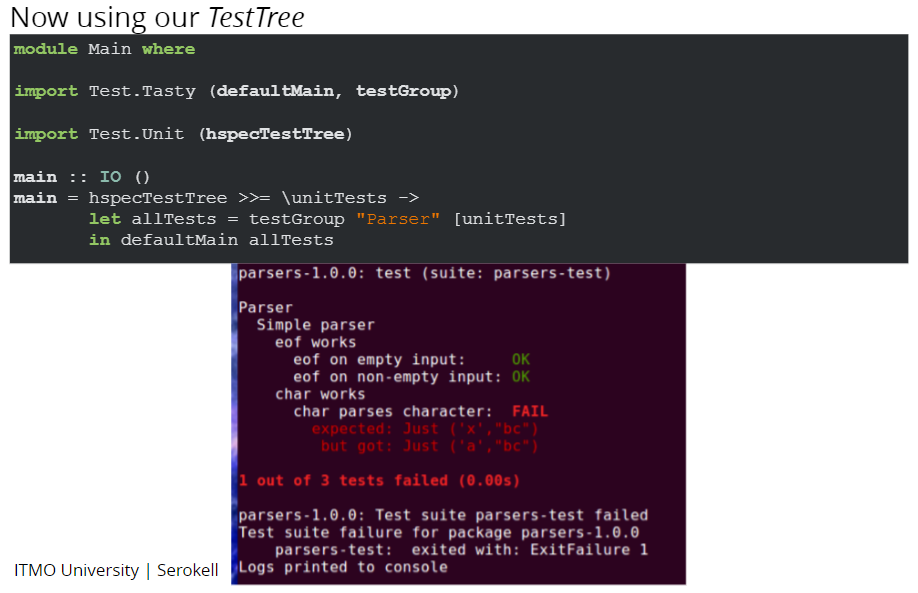

In [2]:
ip.display.Image("img/hspec.png")

### Property-based testing

Property-based testing. Используют автоматическую генерацию тестов. Но для автоматически сгенерированных значений будет неизвестен правильный результат. Нужно явно задать, как что мы применяем ко входным данным и что мы ожидаем получить:

Обычно такие тесты писать сложнее, но они надежнее и покрывают больше случаев.

Пример PBT из Hedgehog

```
import Hedgehog

import qualified Data.List as List
import qualified Hedgehog.Gen as Gen
import qualified Hedgehog.Range as Range

genIntList :: Gen [Int]
genIntList =
  let listLength = Range.linear 0 100000
  in  Gen.list listLength Gen.enumBounded

prop_reverse :: Property
prop_reverse = property $
  forAll genIntList >>= \xs ->
  List.reverse (List.reverse xs) === xs
```

Если тест упадет, то нам нужно понять, что случилось. Но просто выдать упавший тест может быть мало полезным, если он огромный. Поэтому применяется технология Shrinking, которая пытается привести тест к меньшему виду, но чтобы он все еще падал по той же причине, что и полный тест. Это поможет понять, что тестить ручками:

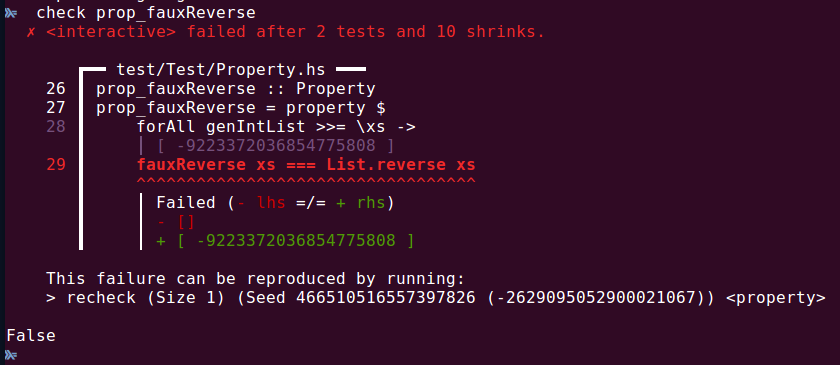

In [4]:
ip.display.Image("img/unit_test_fail.png")

Стандартные применения: проверка обратимых операций и проверка законов для type class(которые однако бывают иногда настолько сложными, что так их не потетстить)

```
read        . show      ≡ id
decode      . encode    ≡ id
deserialize . serialize ≡ id

(a <> b) <> c ≡ a <> (b <> c)
a <> mempty ≡ a
mempty <> a ≡ a
```

## Cont monad

см про монады